In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
import seaborn as sns
import warnings
import piq
import pyiqa

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## 1. Configuration

Set your model path and image path here:

In [ ]:
MODEL_PATH = "../snapshots/Epoch_Final.pth"
IMAGE_PATH = "../data/test_data/lol_dataset/our485/low/17.png"
REFERENCE_PATH = "../data/test_data/lol_dataset/our485/high/17.png"
OUTPUT_DIR = "../analysis_output"

Path(OUTPUT_DIR).mkdir(exist_ok=True)

assert os.path.exists(MODEL_PATH), f"Model not found: {MODEL_PATH}"
assert os.path.exists(IMAGE_PATH), f"Image not found: {IMAGE_PATH}"

## 2. Load Model

Define and load the Zero-DCE enhancement network:

In [ ]:
class enhance_net_nopool(nn.Module):
    def __init__(self):
        super(enhance_net_nopool, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        number_f = 32
        self.e_conv1 = nn.Conv2d(3,number_f,3,1,1,bias=True) 
        self.e_conv2 = nn.Conv2d(number_f,number_f,3,1,1,bias=True) 
        self.e_conv3 = nn.Conv2d(number_f,number_f,3,1,1,bias=True) 
        self.e_conv4 = nn.Conv2d(number_f,number_f,3,1,1,bias=True) 
        self.e_conv5 = nn.Conv2d(number_f*2,number_f,3,1,1,bias=True) 
        self.e_conv6 = nn.Conv2d(number_f*2,number_f,3,1,1,bias=True) 
        self.e_conv7 = nn.Conv2d(number_f*2,24,3,1,1,bias=True) 
        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x):
        x1 = self.relu(self.e_conv1(x))
        x2 = self.relu(self.e_conv2(x1))
        x3 = self.relu(self.e_conv3(x2))
        x4 = self.relu(self.e_conv4(x3))
        x5 = self.relu(self.e_conv5(torch.cat([x3,x4],1)))
        x6 = self.relu(self.e_conv6(torch.cat([x2,x5],1)))
        x_r = F.tanh(self.e_conv7(torch.cat([x1,x6],1)))
        r1,r2,r3,r4,r5,r6,r7,r8 = torch.split(x_r, 3, dim=1)
        
        x = x + r1*(torch.pow(x,2)-x)
        x = x + r2*(torch.pow(x,2)-x)
        x = x + r3*(torch.pow(x,2)-x)
        enhance_image_1 = x + r4*(torch.pow(x,2)-x)
        x = enhance_image_1 + r5*(torch.pow(enhance_image_1,2)-enhance_image_1)
        x = x + r6*(torch.pow(x,2)-x)
        x = x + r7*(torch.pow(x,2)-x)
        enhance_image = x + r8*(torch.pow(x,2)-x)
        r = torch.cat([r1,r2,r3,r4,r5,r6,r7,r8],1)
        return enhance_image_1, enhance_image, r

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = enhance_net_nopool().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

enhance_net_nopool(
  (relu): ReLU(inplace=True)
  (e_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv7): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
)

## 3. Load and Enhance Image

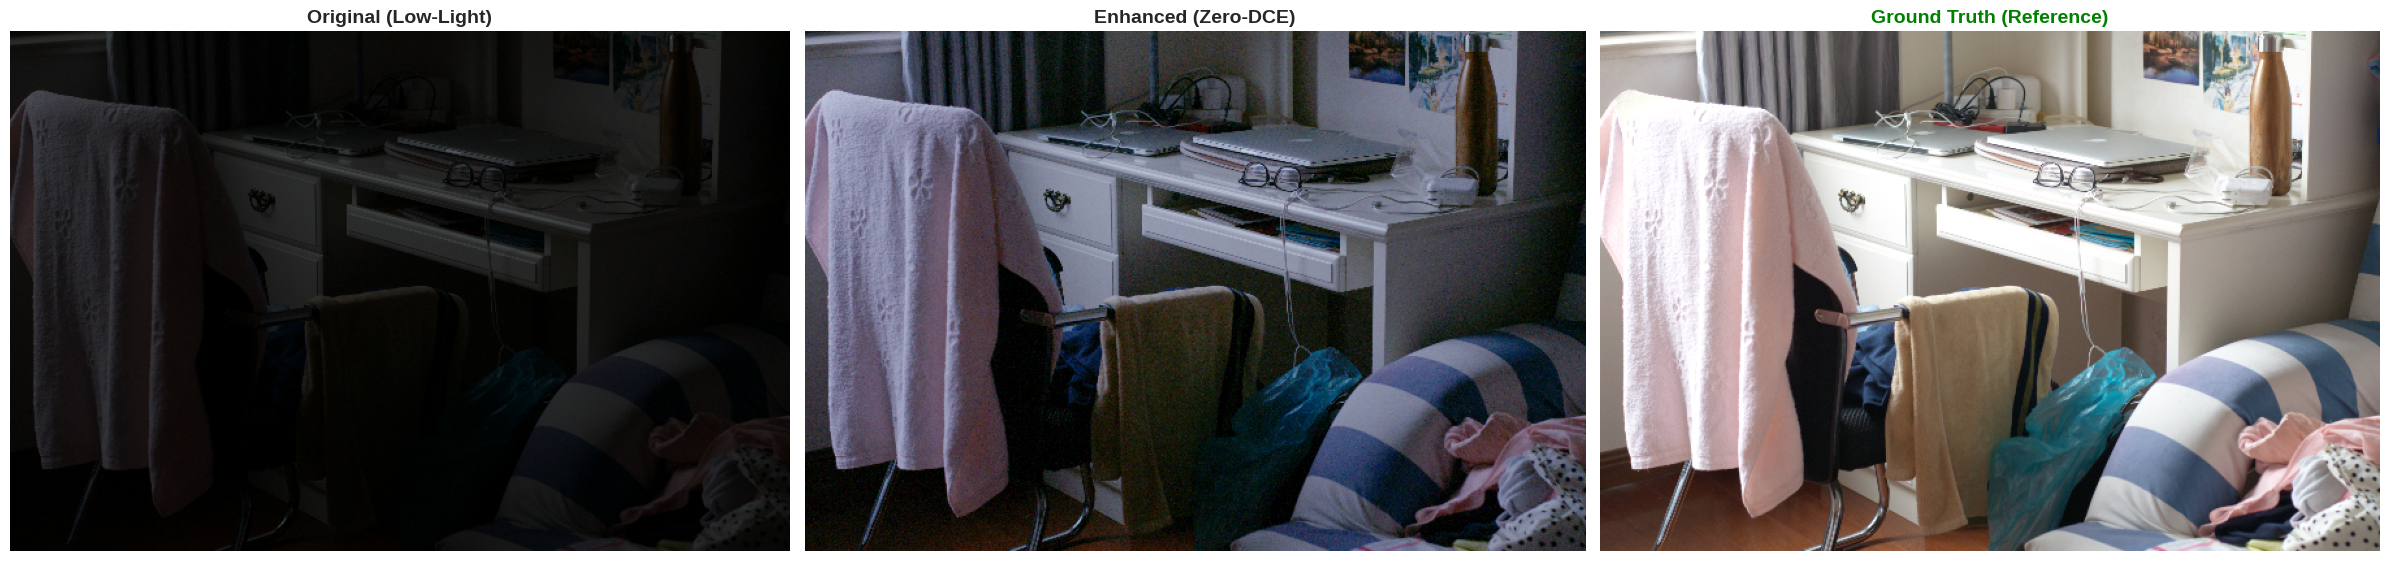

In [ ]:
img_original = Image.open(IMAGE_PATH).convert('RGB')
img_reference = Image.open(REFERENCE_PATH).convert('RGB')

img_tensor = (np.asarray(img_original)/255.0)
img_tensor = torch.from_numpy(img_tensor).float()
img_tensor = img_tensor.permute(2,0,1).unsqueeze(0).to(device)

ref_tensor = (np.asarray(img_reference)/255.0)
ref_tensor = torch.from_numpy(ref_tensor).float()
ref_tensor = ref_tensor.permute(2,0,1).unsqueeze(0).to(device)

with torch.no_grad():
    _, enhanced_tensor, _ = model(img_tensor)

enhanced_np = enhanced_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
enhanced_np = np.clip(enhanced_np * 255, 0, 255).astype('uint8')
original_np = np.array(img_original)
reference_np = np.array(img_reference)

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

axes[0].imshow(original_np)
axes[0].set_title('Original (Low-Light)', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(enhanced_np)
axes[1].set_title('Enhanced (Zero-DCE)', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(reference_np)
axes[2].set_title('Ground Truth (Reference)', fontsize=14, fontweight='bold', color='green')
axes[2].axis('off')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/comparison_with_reference.png", dpi=150, bbox_inches='tight')
plt.show()

## 4. NIQE/BRISQUE Quality Metrics

No-reference image quality assessment (lower scores = better quality):

In [ ]:
# we define niqe and brisque metrics from the pyiqa library
# niqe = naturalness image quality evaluator, so basically how natural an image looks, it compares it to a database of really clear and pristine natural images
# brisque = blind/referenceless image spatial quality evaluator, detects distortions such as blur, noise, compression, artifacts. compares to HUMAN rated image quality database

niqe_metric = pyiqa.create_metric('niqe', device=device)
brisque_metric = pyiqa.create_metric('brisque', device=device)

with torch.no_grad():
    niqe_original = niqe_metric(img_tensor)
    niqe_enhanced = niqe_metric(enhanced_tensor)
    niqe_reference = niqe_metric(ref_tensor)
        
niqe_improvement_enh = niqe_original.item() - niqe_enhanced.item()
        
print(f"\nNIQE (lower = better)")
print(f"  Original:   {niqe_original.item():.3f}")
print(f"  Reference:  {niqe_reference.item():.3f}")
print(f"  Enhanced:   {niqe_enhanced.item():.3f}  (Change: {niqe_improvement_enh:+.3f})")
    
with torch.no_grad():
    brisque_original = brisque_metric(img_tensor)
    brisque_enhanced = brisque_metric(enhanced_tensor)
    brisque_reference = brisque_metric(ref_tensor)

        
brisque_improvement_enh = brisque_original.item() - brisque_enhanced.item()
        
print(f"\nBRISQUE (lower = better)")
print(f"  Original:   {brisque_original.item():.3f}")
print(f"  Reference:  {brisque_reference.item():.3f}")
print(f"  Enhanced:   {brisque_enhanced.item():.3f}  (Change (vs original): {brisque_improvement_enh:+.3f})")


with torch.no_grad():
    psnr_enh = piq.psnr(enhanced_tensor, ref_tensor, data_range=1.0)
    
    ssim_enh = piq.ssim(enhanced_tensor, ref_tensor, data_range=1.0)
    
    mae_enh = torch.mean(torch.abs(enhanced_tensor - ref_tensor))

print(f"\nPSNR (higher = better)")
print(f"  Enhanced vs Reference:   {psnr_enh.item():.3f} dB")

print(f"\nSSIM (higher = better)")
print(f"  Enhanced vs Reference:   {ssim_enh.item():.4f}")

print(f"\nMAE (lower = better)")
print(f"  Enhanced vs Reference:   {mae_enh.item():.4f}")
    


NIQE (lower = better)
  Original:   4.941
  Reference:  3.635
  Enhanced:   6.987  (Change: -2.045)

BRISQUE (lower = better)
  Original:   9.463
  Reference:  13.655
  Enhanced:   28.066  (Change (vs original): -18.603)

PSNR (higher = better, in dB)
  Enhanced vs Reference:   10.436 dB

SSIM (higher = better, 0-1 scale)
  Enhanced vs Reference:   0.6095

MAE (lower = better)
  Enhanced vs Reference:   0.2841


## 5. Brightness Statistics

Comprehensive brightness analysis:

In [ ]:
orig_gray = cv2.cvtColor(original_np, cv2.COLOR_RGB2GRAY)
enh_gray = cv2.cvtColor(enhanced_np, cv2.COLOR_RGB2GRAY)

brightness_stats = {
    'original_mean': orig_gray.mean(),
    'enhanced_mean': enh_gray.mean(),
    'original_std': orig_gray.std(),
    'enhanced_std': enh_gray.std(),
    'original_min': orig_gray.min(),
    'original_max': orig_gray.max(),
    'enhanced_min': enh_gray.min(),
    'enhanced_max': enh_gray.max(),
    'original_p25': np.percentile(orig_gray, 25),
    'original_p50': np.percentile(orig_gray, 50),
    'original_p75': np.percentile(orig_gray, 75),
    'enhanced_p25': np.percentile(enh_gray, 25),
    'enhanced_p50': np.percentile(enh_gray, 50),
    'enhanced_p75': np.percentile(enh_gray, 75),
}

print("Metric               Original        Enhanced        Change")
print(f"Mean Brightness      {brightness_stats['original_mean']:.2f}            "
      f"{brightness_stats['enhanced_mean']:.2f}            "
      f"+{brightness_stats['enhanced_mean'] - brightness_stats['original_mean']:.2f}")
print(f"Std Deviation        {brightness_stats['original_std']:.2f}            "
      f"{brightness_stats['enhanced_std']:.2f}            "
      f"+{brightness_stats['enhanced_std'] - brightness_stats['original_std']:.2f}")
print(f"Min Value            {brightness_stats['original_min']:.0f}              "
      f"{brightness_stats['enhanced_min']:.0f}")
print(f"Max Value            {brightness_stats['original_max']:.0f}             "
      f"{brightness_stats['enhanced_max']:.0f}")
print(f"25th Percentile      {brightness_stats['original_p25']:.1f}            "
      f"{brightness_stats['enhanced_p25']:.1f}")
print(f"Median (50th)        {brightness_stats['original_p50']:.1f}            "
      f"{brightness_stats['enhanced_p50']:.1f}")
print(f"75th Percentile      {brightness_stats['original_p75']:.1f}            "
      f"{brightness_stats['enhanced_p75']:.1f}")


Metric               Original        Enhanced        Change
Mean Brightness      14.61            65.84            +51.23
Std Deviation        13.48            47.43            +33.95
Min Value            0              0
Max Value            99             218
25th Percentile      4.0            23.0
Median (50th)        11.0            59.0
75th Percentile      21.0            101.0


### Brightness Visualizations

/tmp/ipykernel_675/2662545186.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(box_data, labels=['Original', 'Enhanced'], patch_artist=True)


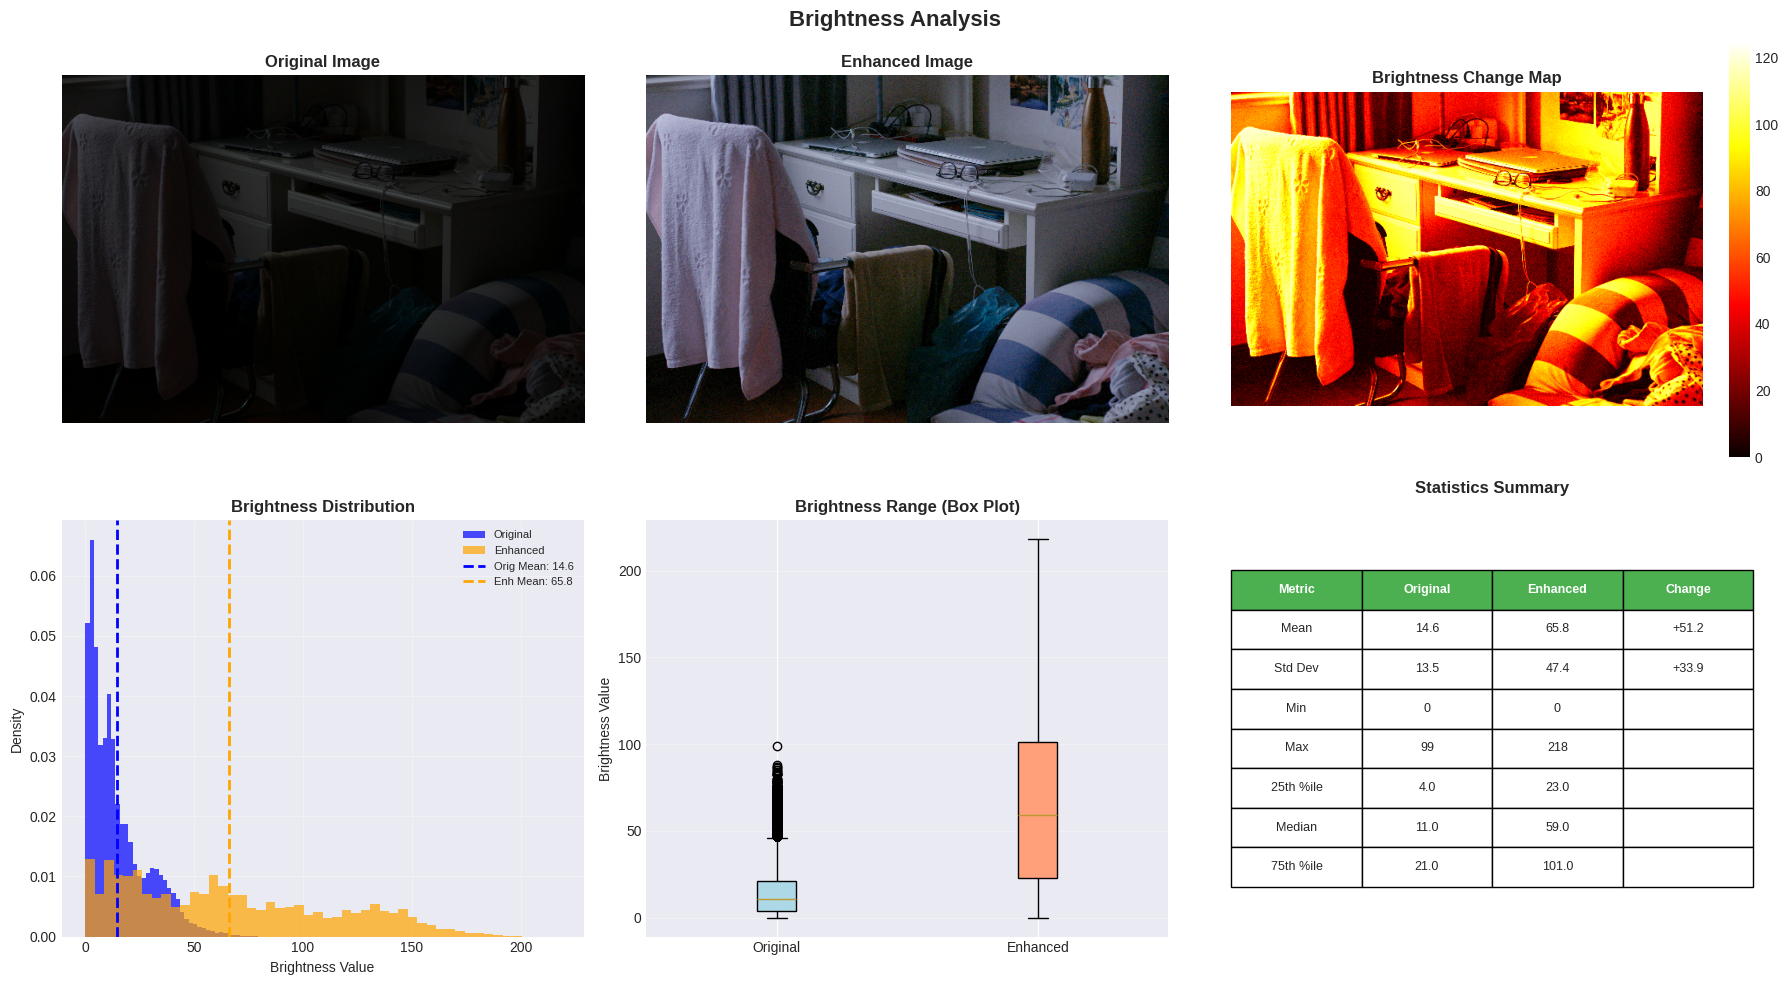

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].imshow(original_np)
axes[0, 0].set_title('Original Image', fontweight='bold', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(enhanced_np)
axes[0, 1].set_title('Enhanced Image', fontweight='bold', fontsize=12)
axes[0, 1].axis('off')

diff = np.abs(enh_gray.astype(float) - orig_gray.astype(float))
im = axes[0, 2].imshow(diff, cmap='hot')
axes[0, 2].set_title('Brightness Change Map', fontweight='bold', fontsize=12)
axes[0, 2].axis('off')
plt.colorbar(im, ax=axes[0, 2], fraction=0.046)

axes[1, 0].hist(orig_gray.ravel(), bins=50, alpha=0.7, label='Original', color='blue', density=True)
axes[1, 0].hist(enh_gray.ravel(), bins=50, alpha=0.7, label='Enhanced', color='orange', density=True)
axes[1, 0].axvline(brightness_stats['original_mean'], color='blue', linestyle='--', linewidth=2, 
                  label=f"Orig Mean: {brightness_stats['original_mean']:.1f}")
axes[1, 0].axvline(brightness_stats['enhanced_mean'], color='orange', linestyle='--', linewidth=2,
                  label=f"Enh Mean: {brightness_stats['enhanced_mean']:.1f}")
axes[1, 0].set_xlabel('Brightness Value', fontsize=10)
axes[1, 0].set_ylabel('Density', fontsize=10)
axes[1, 0].set_title('Brightness Distribution', fontweight='bold', fontsize=12)
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(alpha=0.3)

box_data = [orig_gray.ravel(), enh_gray.ravel()]
bp = axes[1, 1].boxplot(box_data, labels=['Original', 'Enhanced'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightsalmon')
axes[1, 1].set_ylabel('Brightness Value', fontsize=10)
axes[1, 1].set_title('Brightness Range (Box Plot)', fontweight='bold', fontsize=12)
axes[1, 1].grid(alpha=0.3, axis='y')

axes[1, 2].axis('off')
table_data = [
    ['Metric', 'Original', 'Enhanced', 'Change'],
    ['Mean', f"{brightness_stats['original_mean']:.1f}", f"{brightness_stats['enhanced_mean']:.1f}", 
     f"+{brightness_stats['enhanced_mean'] - brightness_stats['original_mean']:.1f}"],
    ['Std Dev', f"{brightness_stats['original_std']:.1f}", f"{brightness_stats['enhanced_std']:.1f}",
     f"+{brightness_stats['enhanced_std'] - brightness_stats['original_std']:.1f}"],
    ['Min', f"{brightness_stats['original_min']:.0f}", f"{brightness_stats['enhanced_min']:.0f}", ''],
    ['Max', f"{brightness_stats['original_max']:.0f}", f"{brightness_stats['enhanced_max']:.0f}", ''],
    ['25th %ile', f"{brightness_stats['original_p25']:.1f}", f"{brightness_stats['enhanced_p25']:.1f}", ''],
    ['Median', f"{brightness_stats['original_p50']:.1f}", f"{brightness_stats['enhanced_p50']:.1f}", ''],
    ['75th %ile', f"{brightness_stats['original_p75']:.1f}", f"{brightness_stats['enhanced_p75']:.1f}", ''],
]

table = axes[1, 2].table(cellText=table_data, cellLoc='center', loc='center',
                        colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

for i in range(4):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

axes[1, 2].set_title('Statistics Summary', fontweight='bold', fontsize=12, pad=20)

plt.suptitle('Brightness Analysis', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/brightness_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

## 6. Contrast Metrics

Global and local contrast analysis:

In [ ]:
def calculate_local_std(image, kernel_size=15):
    mean = cv2.blur(image.astype(np.float32), (kernel_size, kernel_size))
    mean_sq = cv2.blur((image.astype(np.float32))**2, (kernel_size, kernel_size))
    variance = mean_sq - mean**2
    variance = np.maximum(variance, 0)
    std = np.sqrt(variance)
    return std

contrast_metrics = {}

# michelson contrast: relative contrast betwenn brightest and most dark pixels, so good in our case bcs we have clear bright/dark regions 
contrast_metrics['original_michelson'] = (orig_gray.max() - orig_gray.min()) / (orig_gray.max() + orig_gray.min() + 1e-6)
contrast_metrics['enhanced_michelson'] = (enh_gray.max() - enh_gray.min()) / (enh_gray.max() + enh_gray.min() + 1e-6)

# rms (root mean square): std of the pixel intensities, so pretty much how much the pixels vary from the mean brightness
contrast_metrics['original_rms'] = orig_gray.std()
contrast_metrics['enhanced_rms'] = enh_gray.std()

# weber contrast: maybe not relevant, calculates how much the brightest region pops out from average
contrast_metrics['original_weber'] = (orig_gray.max() - orig_gray.mean()) / (orig_gray.mean() + 1e-6)
contrast_metrics['enhanced_weber'] = (enh_gray.max() - enh_gray.mean()) / (enh_gray.mean() + 1e-6)

# dynamic range: total span of brightnesss values in the image, so like if the brightest pixel is 255 and the darkest is 30, range = 255 - 30 = 225
contrast_metrics['original_range'] = orig_gray.max() - orig_gray.min()
contrast_metrics['enhanced_range'] = enh_gray.max() - enh_gray.min()

orig_local_std = calculate_local_std(orig_gray)
enh_local_std = calculate_local_std(enh_gray)

contrast_metrics['original_local_mean'] = orig_local_std.mean()
contrast_metrics['enhanced_local_mean'] = enh_local_std.mean()
contrast_metrics['original_local_std'] = orig_local_std.std()
contrast_metrics['enhanced_local_std'] = enh_local_std.std()

orig_gradx = cv2.Sobel(orig_gray, cv2.CV_64F, 1, 0, ksize=3)
orig_grady = cv2.Sobel(orig_gray, cv2.CV_64F, 0, 1, ksize=3)
orig_gradient = np.sqrt(orig_gradx**2 + orig_grady**2)

enh_gradx = cv2.Sobel(enh_gray, cv2.CV_64F, 1, 0, ksize=3)
enh_grady = cv2.Sobel(enh_gray, cv2.CV_64F, 0, 1, ksize=3)
enh_gradient = np.sqrt(enh_gradx**2 + enh_grady**2)

contrast_metrics['original_edge_strength'] = orig_gradient.mean()
contrast_metrics['enhanced_edge_strength'] = enh_gradient.mean()

print("Originial vs Enhanced:")

print(f"{'Michelson Contrast':<30} {contrast_metrics['original_michelson']:>14.4f} "
      f"{contrast_metrics['enhanced_michelson']:>14.4f}")
print(f"{'RMS Contrast (Std Dev)':<30} {contrast_metrics['original_rms']:>14.2f} "
      f"{contrast_metrics['enhanced_rms']:>14.2f}")
print(f"{'Weber Contrast':<30} {contrast_metrics['original_weber']:>14.4f} "
      f"{contrast_metrics['enhanced_weber']:>14.4f}")
print(f"{'Dynamic Range':<30} {contrast_metrics['original_range']:>14.0f} "
      f"{contrast_metrics['enhanced_range']:>14.0f}")

print(f"{'Mean Local Std Dev':<30} {contrast_metrics['original_local_mean']:>14.2f} "
      f"{contrast_metrics['enhanced_local_mean']:>14.2f}")
print(f"{'Std of Local Std Dev':<30} {contrast_metrics['original_local_std']:>14.2f} "
      f"{contrast_metrics['enhanced_local_std']:>14.2f}")
print(f"{'Mean Edge Strength':<30} {contrast_metrics['original_edge_strength']:>14.2f} "
      f"{contrast_metrics['enhanced_edge_strength']:>14.2f}")


Originial vs Enhanced:
Michelson Contrast                     1.0000         1.0000
RMS Contrast (Std Dev)                  13.48          47.43
Weber Contrast                         5.7743         2.3109
Dynamic Range                              99            218
Mean Local Std Dev                       5.03          17.94
Std of Local Std Dev                     4.36          12.81
Mean Edge Strength                      15.27          54.56


### Contrast Visualizations

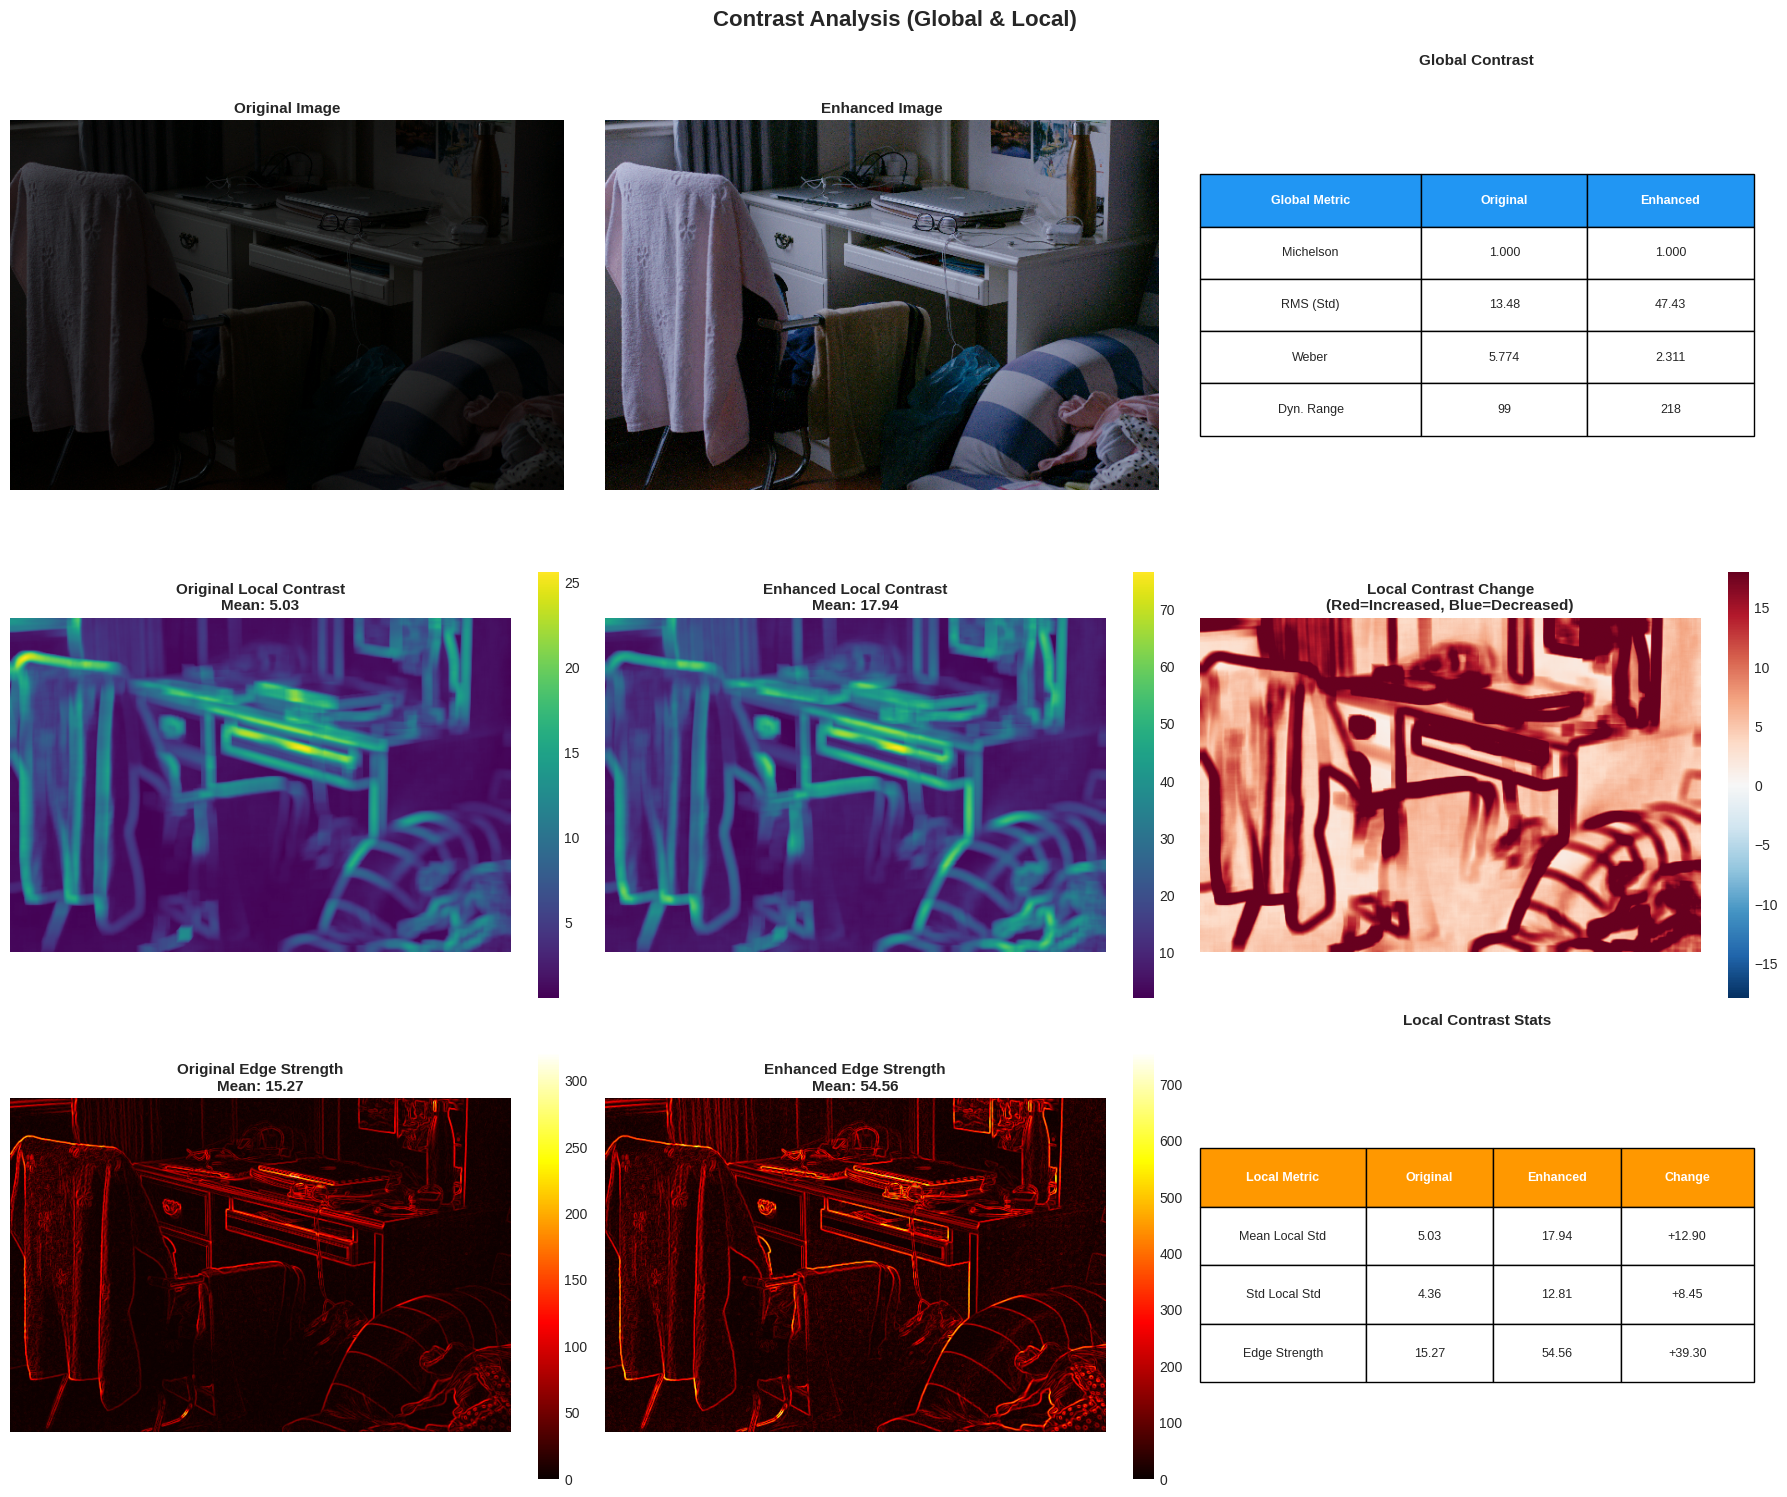

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

axes[0, 0].imshow(original_np)
axes[0, 0].set_title('Original Image', fontweight='bold', fontsize=11)
axes[0, 0].axis('off')

axes[0, 1].imshow(enhanced_np)
axes[0, 1].set_title('Enhanced Image', fontweight='bold', fontsize=11)
axes[0, 1].axis('off')

axes[0, 2].axis('off')
global_table = [
    ['Global Metric', 'Original', 'Enhanced'],
    ['Michelson', f"{contrast_metrics['original_michelson']:.3f}", f"{contrast_metrics['enhanced_michelson']:.3f}"],
    ['RMS (Std)', f"{contrast_metrics['original_rms']:.2f}", f"{contrast_metrics['enhanced_rms']:.2f}"],
    ['Weber', f"{contrast_metrics['original_weber']:.3f}", f"{contrast_metrics['enhanced_weber']:.3f}"],
    ['Dyn. Range', f"{contrast_metrics['original_range']:.0f}", f"{contrast_metrics['enhanced_range']:.0f}"],
]

table = axes[0, 2].table(cellText=global_table, cellLoc='center', loc='center',
                        colWidths=[0.4, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.5)

for i in range(3):
    table[(0, i)].set_facecolor('#2196F3')
    table[(0, i)].set_text_props(weight='bold', color='white')

axes[0, 2].set_title('Global Contrast', fontweight='bold', fontsize=11, pad=20)

im1 = axes[1, 0].imshow(orig_local_std, cmap='viridis')
axes[1, 0].set_title(f'Original Local Contrast\nMean: {contrast_metrics["original_local_mean"]:.2f}', 
                    fontweight='bold', fontsize=11)
axes[1, 0].axis('off')
plt.colorbar(im1, ax=axes[1, 0], fraction=0.046)

im2 = axes[1, 1].imshow(enh_local_std, cmap='viridis')
axes[1, 1].set_title(f'Enhanced Local Contrast\nMean: {contrast_metrics["enhanced_local_mean"]:.2f}', 
                    fontweight='bold', fontsize=11)
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1], fraction=0.046)

local_diff = enh_local_std - orig_local_std
im3 = axes[1, 2].imshow(local_diff, cmap='RdBu_r', vmin=-local_diff.std()*2, vmax=local_diff.std()*2)
axes[1, 2].set_title('Local Contrast Change\n(Red=Increased, Blue=Decreased)', 
                    fontweight='bold', fontsize=11)
axes[1, 2].axis('off')
plt.colorbar(im3, ax=axes[1, 2], fraction=0.046)

im4 = axes[2, 0].imshow(orig_gradient, cmap='hot')
axes[2, 0].set_title(f'Original Edge Strength\nMean: {contrast_metrics["original_edge_strength"]:.2f}', 
                    fontweight='bold', fontsize=11)
axes[2, 0].axis('off')
plt.colorbar(im4, ax=axes[2, 0], fraction=0.046)

im5 = axes[2, 1].imshow(enh_gradient, cmap='hot')
axes[2, 1].set_title(f'Enhanced Edge Strength\nMean: {contrast_metrics["enhanced_edge_strength"]:.2f}', 
                    fontweight='bold', fontsize=11)
axes[2, 1].axis('off')
plt.colorbar(im5, ax=axes[2, 1], fraction=0.046)

axes[2, 2].axis('off')
local_table = [
    ['Local Metric', 'Original', 'Enhanced', 'Change'],
    ['Mean Local Std', f"{contrast_metrics['original_local_mean']:.2f}", 
     f"{contrast_metrics['enhanced_local_mean']:.2f}",
     f"+{contrast_metrics['enhanced_local_mean'] - contrast_metrics['original_local_mean']:.2f}"],
    ['Std Local Std', f"{contrast_metrics['original_local_std']:.2f}",
     f"{contrast_metrics['enhanced_local_std']:.2f}",
     f"+{contrast_metrics['enhanced_local_std'] - contrast_metrics['original_local_std']:.2f}"],
    ['Edge Strength', f"{contrast_metrics['original_edge_strength']:.2f}",
     f"{contrast_metrics['enhanced_edge_strength']:.2f}",
     f"+{contrast_metrics['enhanced_edge_strength'] - contrast_metrics['original_edge_strength']:.2f}"],
]

table2 = axes[2, 2].table(cellText=local_table, cellLoc='center', loc='center',
                         colWidths=[0.3, 0.23, 0.23, 0.24])
table2.auto_set_font_size(False)
table2.set_fontsize(9)
table2.scale(1, 2.8)

for i in range(4):
    table2[(0, i)].set_facecolor('#FF9800')
    table2[(0, i)].set_text_props(weight='bold', color='white')

axes[2, 2].set_title('Local Contrast Stats', fontweight='bold', fontsize=11, pad=20)

plt.suptitle('Contrast Analysis (Global & Local)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/contrast_analysis.png", dpi=150, bbox_inches='tight')
plt.show()